In [1]:
import scanpy as sc
import pandas as pd
from pathlib import Path
import anndata as ad
import numpy as np
import os
import scvi

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

DPI = 300
FONTSIZE = 20  # 42

sc.settings.set_figure_params(
    scanpy=True, dpi=100, transparent=True, vector_friendly=True, dpi_save=DPI
)
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42

Global seed set to 0


In [2]:
DIR2SAVE = Path(
    "/data/BCI-CRC/nasrine/data/CRC/Metastatic_CRC_LM_dataset/subpopulations/Myeloid/scvi_latent20/alternative_version/"
)
DIR2SAVE.mkdir(parents=True, exist_ok=True)

In [3]:
DIR2LOAD = Path(
    "/data/BCI-CRC/nasrine/data/CRC/Metastatic_CRC_LM_dataset/subpopulations/Myeloid/scvi_latent20"
)

In [4]:
FIG2SAVE = DIR2SAVE.joinpath("figures/")
FIG2SAVE.mkdir(parents=True, exist_ok=True)
# set the global variable: sc.settings.figdir to save all plots
sc.settings.figdir = FIG2SAVE

In [5]:
adata = sc.read_h5ad(
    DIR2LOAD.joinpath(
        "Multiome_Che_Wu_CRC_LM_integrated_scvi_hvg_Myeloid_clustering.h5ad"
    )
)

In [6]:
adata

AnnData object with n_obs × n_vars = 19398 × 2000
    obs: 'Patient', 'Sample', 'Cell_type', 'Cell_subtype', 'Tissue', 'Therapy', 'doublet_score', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'cell_source', 'Annotation_scVI', 'S_score', 'G2M_score', 'phase', 'cell_cycle_diff', '_scvi_batch', '_scvi_labels', 'leiden_scVI', 'leiden_scVI_r1.5', 'leiden_scVI_r1'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'Cell_subtype_colors', 'Cell_type_colors', 'Therapy_colors', 'Tissue_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_source_colors', 'dendrogram_leiden_scVI', 'hvg', 'leiden', 'leiden_scVI_colors', 'leiden_scVI_r1.5_colors', 'leiden_scVI_r1_colors', 'log1p', 'neighbors', 'pca', 'phase_colors', 'rank_genes_wilcoxon', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    varm: 'PCs'
    layers: 'log1p', 'norma

In [9]:
adata.obs.leiden_scVI.value_counts()

0     2075
1     2038
2     1739
3     1541
4     1434
5     1402
6     1055
7     1012
8      999
9      912
10     786
11     776
12     617
13     600
14     513
15     507
16     387
17     342
18     241
19     235
20     109
21      78
Name: leiden_scVI, dtype: int64

In [18]:
cluster_cellsource_df = (
    adata.obs[["leiden_scVI", "cell_source"]]
    .groupby(["leiden_scVI", "cell_source"])
    .size()
    .reset_index()
)

cluster_cellsource_df[cluster_cellsource_df["leiden_scVI"] == "9"]

,leiden_scVI,cell_source,0
27,9,BCI-Nuclei,80
28,9,Che-Cells,499
29,9,Wu-Cells,333


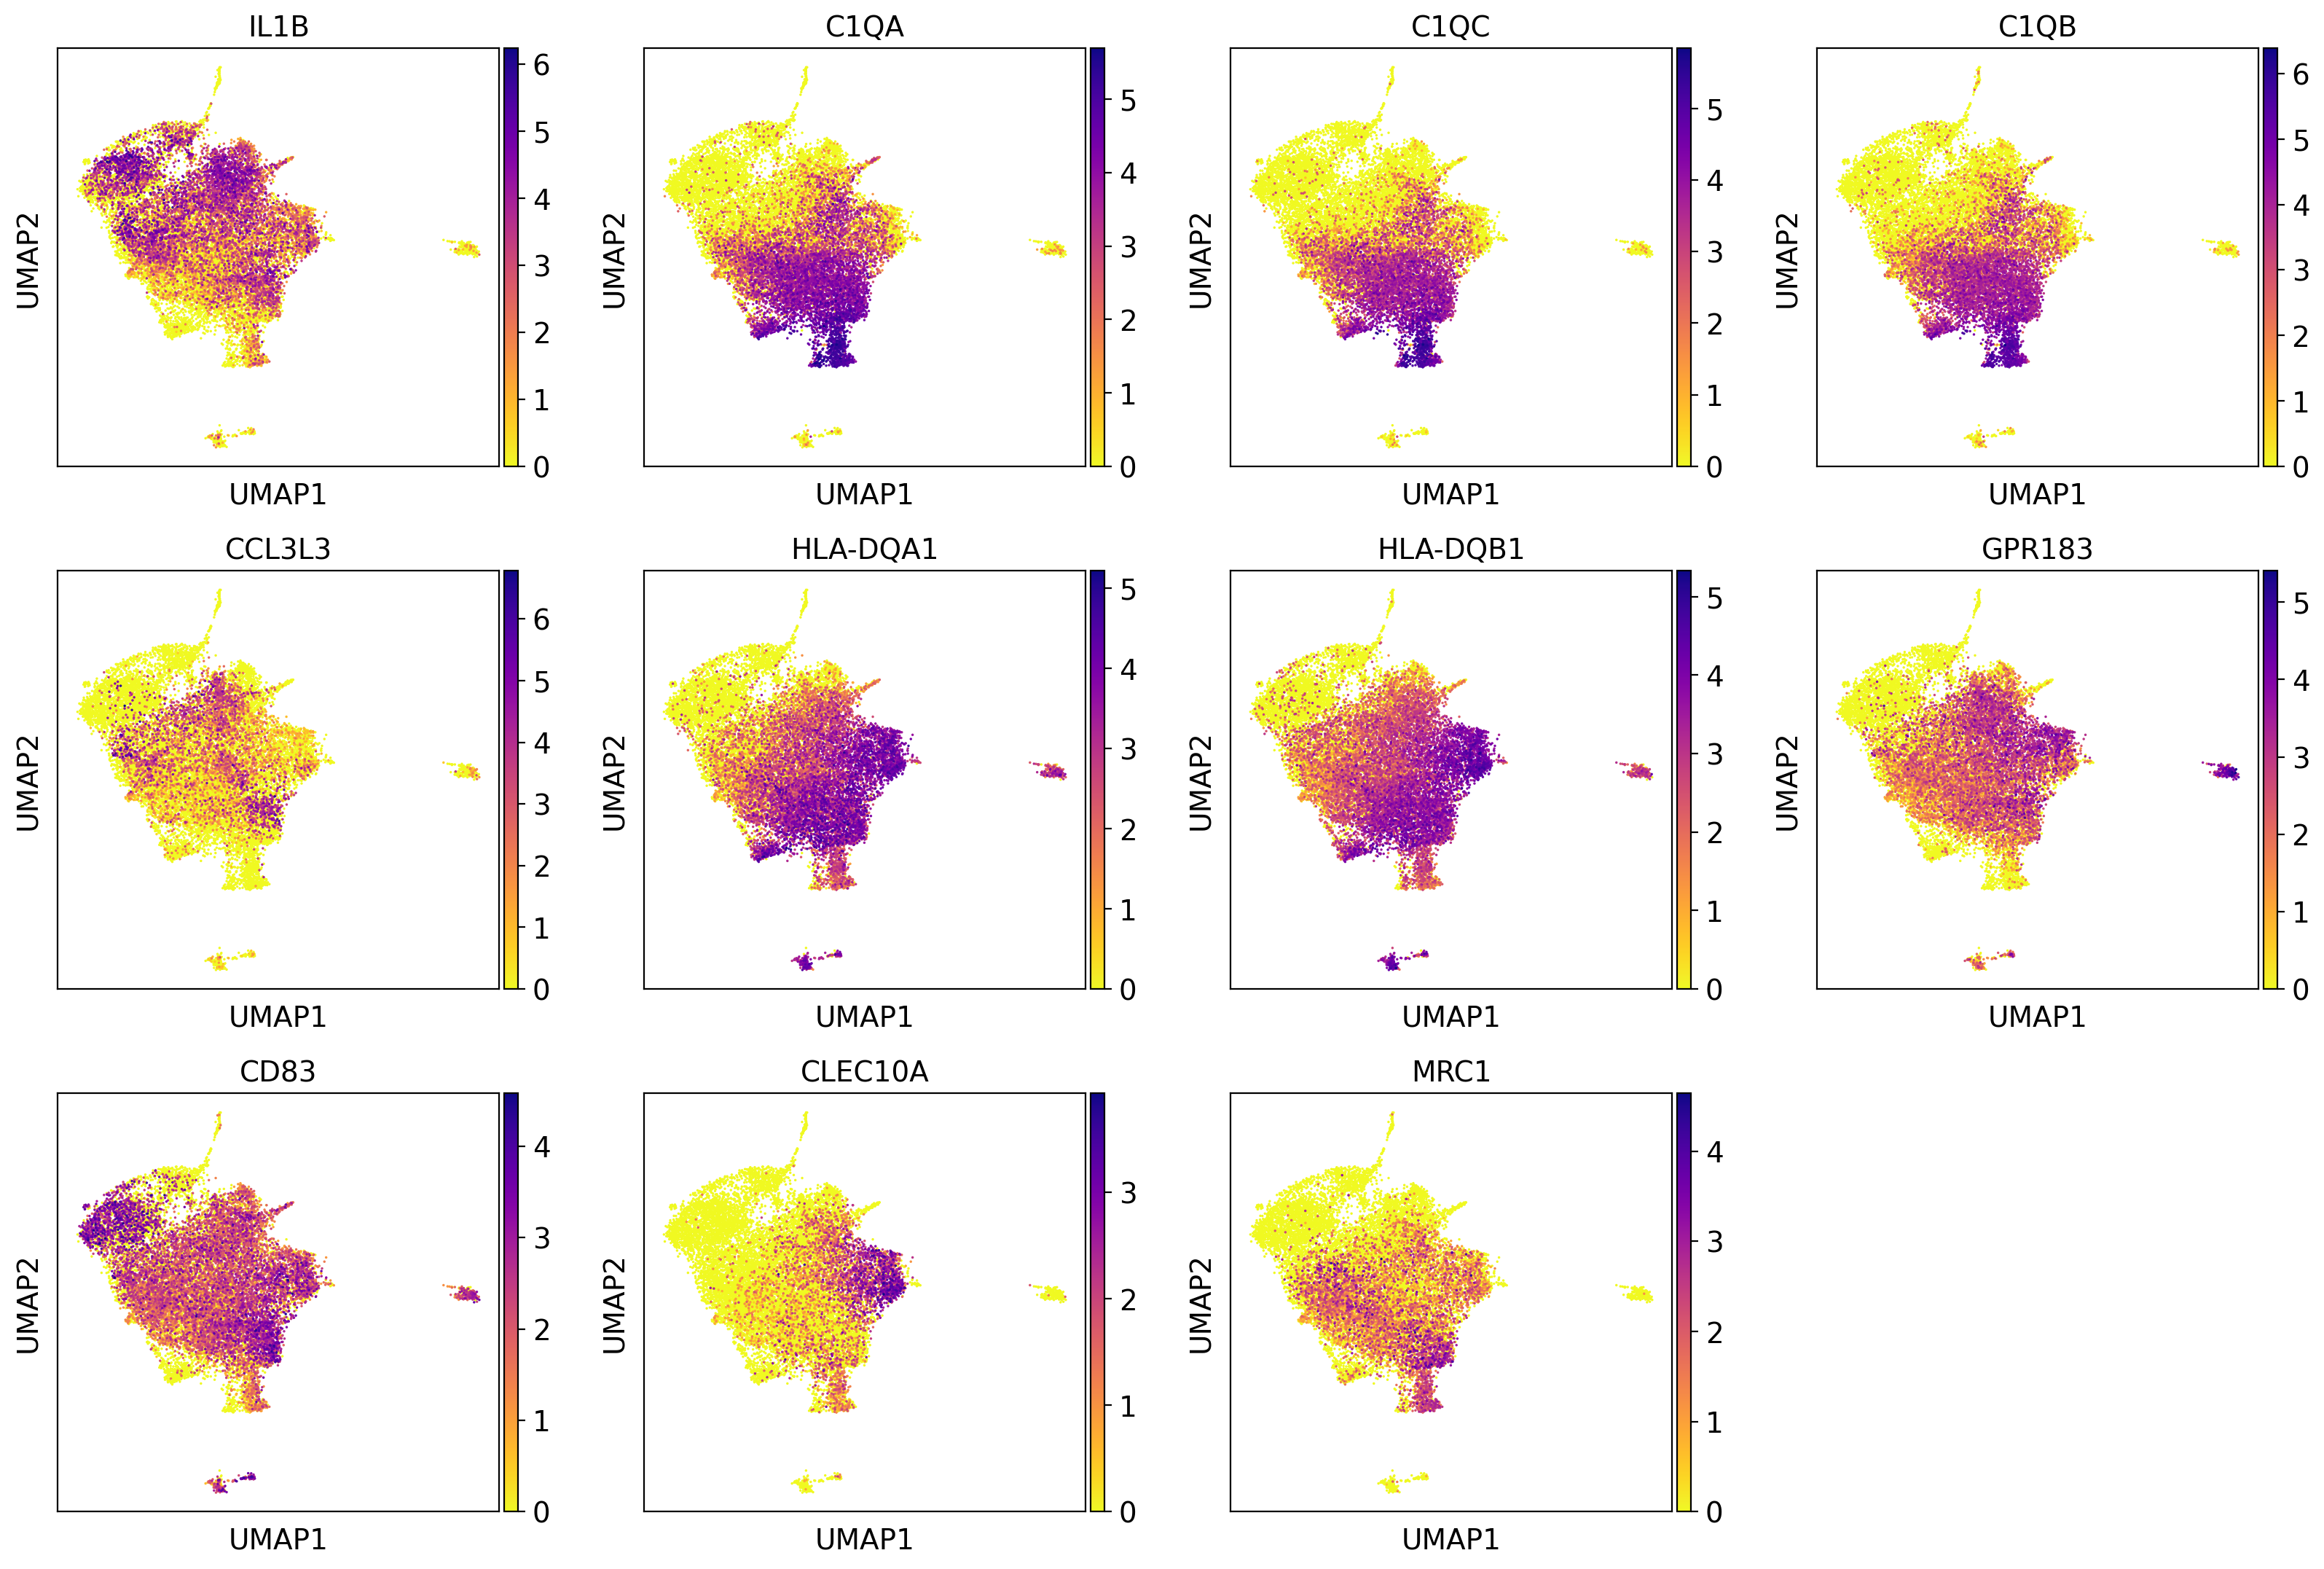

In [8]:
sc.pl.umap(
    adata,
    color=[
        "IL1B",
        "C1QA",
        "C1QC",
        "C1QB",
        "CCL3L3",
        "HLA-DQA1",
        "HLA-DQB1",
        "GPR183",
        "CD83",
        "CLEC10A",
        "MRC1",
    ],
    use_raw=True,
    color_map="plasma_r",
)

### Annotations

In [9]:
old_to_new = {
    "0": "NLRP3 Mac",
    "1": "Neutrophil",
    "2": "C1QC-PLTP-IL1B Mac",  # before it was PLTP
    "3": "DC",
    "4": "M-T doublet",
    "5": "SPP1 Mac",
    "6": "C1QC Mac",
    "7": "SPP1 Mac",
    "8": "FCN1 Mono",
    "9": "SPP1 Mac",
    "10": "SPP1 Mac",
    "11": "Neutrophil",
    "12": "C1QC Mac with B cell contamination",
    "13": "Kupffer",
    "14": "Myeloid cycling",
    "15": "SPP1 Mac",  # before it was IL1B
    "16": "HSP Mono",
    "17": "C1QC Mac",
    "18": "DC",
    "19": "DC",
    "20": "B doublet",
    "21": "Neutrophil",
}

* 0: NLRP3 Mac like in Zhang paper: NLRP3, IL1B, VCAN, S100A8, S100A9, S100A12, EREG
* 1: Neutrophil
* 2: C1QC Mac with IL1B mix and PLTP, SEPP1, SNX6, STAB1, CXCL3 similar to C1QC/IL1B/PLTP 
* 3: cDC2 but grouped as DC to re-cluster
* 4: T cell contamination
* 5: SPP1 Mac because SPP1, ADM, FN1, MARCO, PPARG, 
* 6: C1QC because C1QC markers 
* 7: SPP1 Mac because SPP1, SDC4, CSTB, FN1, MARCO, 
* 8: FCN1 Mono because FCN1, HSPA1A, HSPA1B
* 9: SPP1 Mac because SPP1, SDC4, CSTB, FN1, MARCO, RGCC
* 10: SPP1 Mac because FN1, PPARG, SPP1
* 11: Neutrophil
* 12: C1QC but Che has lot of B cell contamination
* 13: Kupffer
* 14: Myeloid cycling --> for spatial should we remove cycling stuff?
* 15: SPP1 Mac (has a little bit of IL1B, CCL3)
* 16: HSP Mono because a lot of HSP
* 17: C1QC Mac 
* 18: pDC but grouped as DC to re-cluster
* 19: cDC1/migDC but grouped as DC to re-cluster
* 20: B cell contamination with CD79B from che 
* 21: Neutrophil

In [10]:
adata.obs["Annotation_scVI_detailed"] = (
    adata.obs["leiden_scVI"].map(old_to_new).astype("category")
)

### Before removal of bad clusters

In [11]:
# set colours for dataset, need to know order
adata.obs.Annotation_scVI_detailed.cat.categories.values.tolist()

['B doublet',
 'C1QC Mac',
 'C1QC Mac with B cell contamination',
 'C1QC-PLTP-IL1B Mac',
 'DC',
 'FCN1 Mono',
 'HSP Mono',
 'Kupffer',
 'M-T doublet',
 'Myeloid cycling',
 'NLRP3 Mac',
 'Neutrophil',
 'SPP1 Mac']

In [12]:
adata.uns["Annotation_scVI_detailed_colors"] = [
    "#9ebcda",
    "#80b1d3",
    "#810f7c",
    "#fccde5",
    "#bebada",
    "#b3de69",
    "#e31a1c",
    "#e78ac3",
    "#f768a1",
    "#ffff99",
    "#fdb462",
    "#1f78b4",
    "#8dd3c7",
]

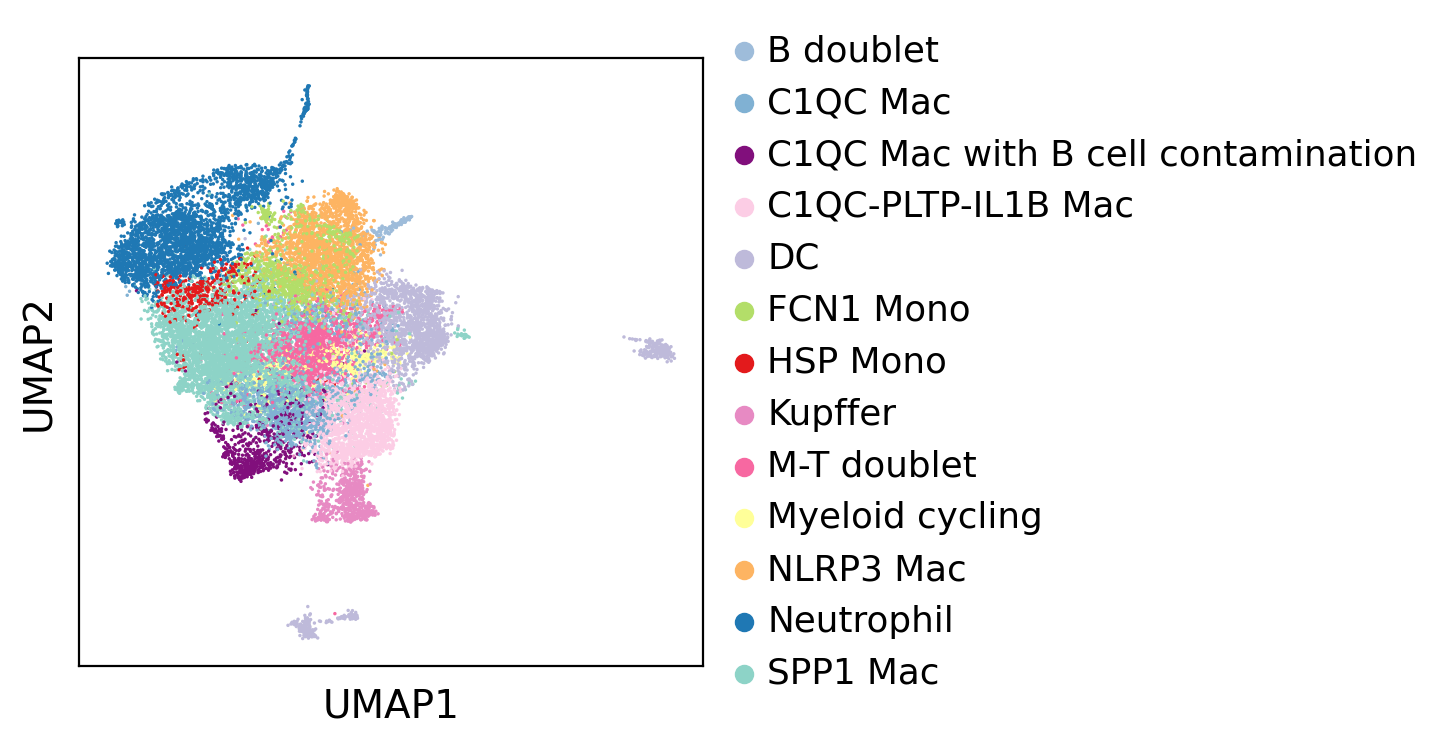

In [14]:
sc.pl.umap(
    adata,
    color="Annotation_scVI_detailed",
    show=True,
    legend_loc="right margin",
    save="annotations_before_removal_bad_clusters.pdf",
    title="",
)

### After removal of bad clusters 

In [15]:
adata = adata[
    ~adata.obs["Annotation_scVI_detailed"].isin(
        [
            "B doublet",
            "C1QC Mac with B cell contamination",
            "M-T doublet",
        ]
    )
].copy()

In [16]:
adata.obs["Annotation_scVI_detailed"].value_counts()

SPP1 Mac              4619
Neutrophil            2892
NLRP3 Mac             2075
DC                    2017
C1QC-PLTP-IL1B Mac    1739
C1QC Mac              1397
FCN1 Mono              999
Kupffer                600
Myeloid cycling        513
HSP Mono               387
Name: Annotation_scVI_detailed, dtype: int64

### Change colours 

In [17]:
# set colours for dataset, need to know order
adata.obs.Annotation_scVI_detailed.cat.categories.values.tolist()

['C1QC Mac',
 'C1QC-PLTP-IL1B Mac',
 'DC',
 'FCN1 Mono',
 'HSP Mono',
 'Kupffer',
 'Myeloid cycling',
 'NLRP3 Mac',
 'Neutrophil',
 'SPP1 Mac']

In [18]:
adata.uns["Annotation_scVI_detailed_colors"] = [
    "#80b1d3",
    "#fccde5",
    "#bebada",
    "#b3de69",
    "#e31a1c",
    "#e78ac3",
    "#ffff99",
    "#fdb462",
    "#1f78b4",
    "#8dd3c7",
]

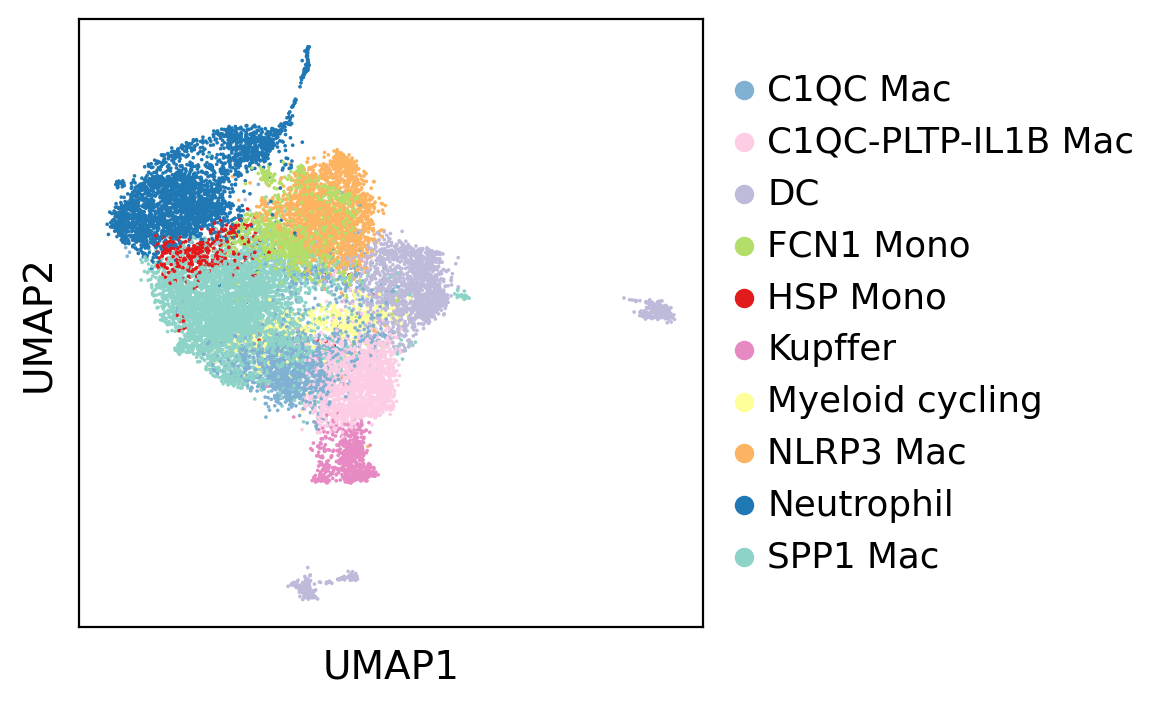

In [19]:
sc.pl.umap(
    adata,
    color="Annotation_scVI_detailed",
    show=True,
    legend_loc="right margin",
    save="annotations.pdf",
    title="",
)

In [21]:
# write to file
adata.write(
    DIR2SAVE.joinpath(
        "Multiome_Che_Wu_CRC_LM_integrated_scvi_hvg_Myeloid_clustering_annotations.h5ad"
    )
)